In [ ]:
# pip install pandas numpy shap xgboost azure-ai-openai azure-identity tabulate
# pip install -r requirements.txt

In [1]:
import sys
import os

# sys.path.append("../risk_model")  # Adjust path as needed
# sys.path.append("./risk_model")
# sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
os.path.dirname(os.getcwd()), os.getcwd()

('/Users/leiyu/Projects/coding', '/Users/leiyu/Projects/coding/risk_model')

### 1. Load Libraries & Config

In [98]:
%load_ext autoreload
%autoreload 2

import shap
from config import AZURE_OPENAI_ENDPOINT, AZURE_OPENAI_API_KEY, DEPLOYMENT_NAME, TOP_N_FEATURES
# from data.data_loader import generate_synthetic_data, generate_feature_library_csv
from data.data_loader import (
    generate_feature_library_csv,
    generate_dummy_dataset,
    generate_and_save_aml_data,
    load_dataset
)

from data.feature_library import load_feature_descriptions
from model.trainer import train_xgboost
from model.explainer import compute_shap_values
from narrative.prompt_generator import build_prompt
# from narrative.azure_openai_client import get_azure_openai_client, generate_narrative

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Generate Data

In [99]:
# Generate feature library
generate_feature_library_csv("data/feature_library.csv")

# Generate dummy dataset and save it
dummy_df = generate_and_save_aml_data(num_samples=1000, fraud_ratio=0.3)
dummy_df.to_csv("data/dummy_aml_data.csv", index=False)

# Load dataset
X, y = load_dataset("data/dummy_aml_data.csv")

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(y.value_counts())

✅ Feature library CSV saved to data/feature_library.csv
✅ Data generated and saved to data/aml_data.csv
✅ Dataset loaded from data/dummy_aml_data.csv with shape (1000, 13)
X shape: (1000, 12)
y shape: (1000,)
risk_label
0    700
1    300
Name: count, dtype: int64


In [111]:
# y

### 3. Train Model

In [101]:
model, X_test = train_xgboost(X, y)

### 4. Explain One Example

In [102]:
entity_index = 10
entity_features = X_test.iloc[[entity_index]]
# risk_score = model.predict(entity_features)[0]
risk_score = model.predict_proba(entity_features)[0, 1]

In [103]:
risk_score

np.float32(0.068558015)

### 5. Compute SHAP Values

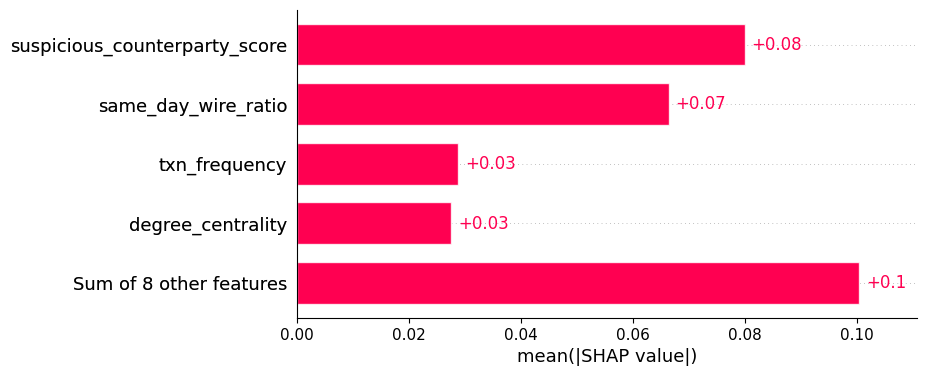

In [104]:
top_features = compute_shap_values(model, X, entity_features, TOP_N_FEATURES)

In [105]:
top_features

,Feature,SHAP Value,Abs SHAP Value
11,suspicious_counterparty_score,-0.079898,0.079898
5,same_day_wire_ratio,-0.066318,0.066318
3,txn_frequency,-0.028777,0.028777
2,degree_centrality,-0.027569,0.027569
10,txn_amount_std,-0.026311,0.026311


In [110]:
# print(X.describe())

/var/folders/lj/sq_z3m_s3z51_g2s4qfv2hrw0000gn/T/ipykernel_72543/1747311747.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


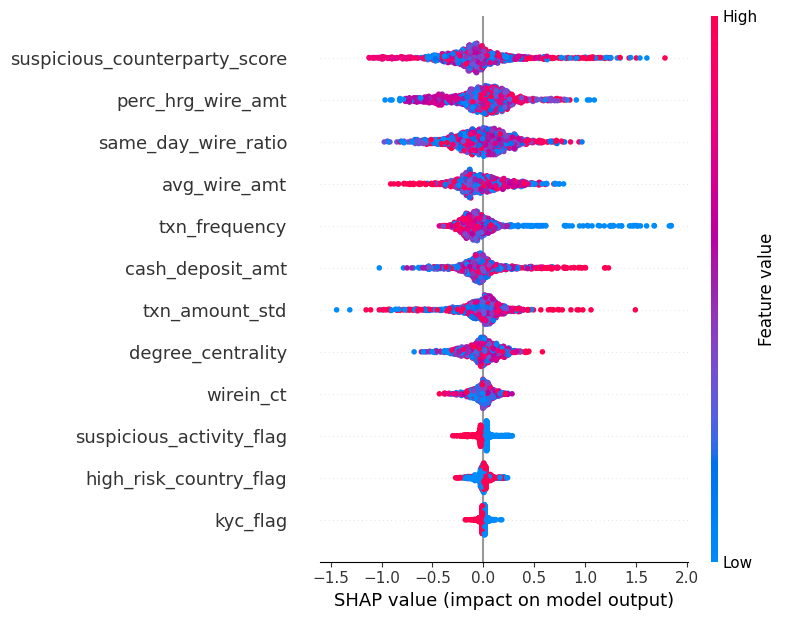

In [107]:
# 1. Create the explainer for your model
explainer = shap.TreeExplainer(model)

# 2. Calculate SHAP values for your dataset X
shap_values = explainer.shap_values(X)

# 3. Plot summary
shap.summary_plot(shap_values, X)

### 6. Load Feature Descriptions

In [108]:
feature_descriptions = load_feature_descriptions(feature_names=X.columns)

### 7. Build Prompt

In [109]:
prompt = build_prompt(risk_score, top_features, feature_descriptions)
print("=== Prompt to LLM ===")
print(prompt)

=== Prompt to LLM ===
You are a risk model explanation assistant. Given a risk score and a list of features with their descriptions and contributions, generate a clear, concise narrative explaining the risk score.

Risk Score: 6.86%

Top Features and Contributions:
- suspicious_counterparty_score (suspicious_counterparty_score): This feature decreased the risk score, contributing 34.9% of the total impact.
- same_day_wire_ratio (same_day_wire_ratio): This feature decreased the risk score, contributing 29.0% of the total impact.
- txn_frequency (txn_frequency): This feature decreased the risk score, contributing 12.6% of the total impact.
- degree_centrality (degree_centrality): This feature decreased the risk score, contributing 12.0% of the total impact.
- txn_amount_std (txn_amount_std): This feature decreased the risk score, contributing 11.5% of the total impact.

Please produce a narrative that:
- Starts with the risk score.
- Explains how each feature contributed to the score, in

### 8. Call Azure OpenAI

In [ ]:
client = get_azure_openai_client(AZURE_OPENAI_ENDPOINT)
narrative = generate_narrative(client, DEPLOYMENT_NAME, prompt)
print("=== LLM Narrative ===")
print(narrative)

### 9. Summarize

In [ ]:
summary_table = pd.DataFrame({
    "Entity Index": [entity_index],
    "Predicted Risk Score (%)": [round(risk_score * 100, 2)],
    "Top Features": [", ".join(top_features['Feature'])],
    "Narrative": [narrative],
    "Evaluation Score": ["N/A (manual review recommended)"]
})

print(tabulate(summary_table, headers="keys", tablefmt="fancy_grid", showindex=False))